In [1]:
import sys
import os
from itertools import combinations

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class MicrogliaTrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "MICROGLIA_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # file load UI
        self.layout_file_load = QHBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 2)
        # extra UI (bottom)
        self.layout_extra_ui = QHBoxLayout()
        self.layout_main.addLayout(self.layout_extra_ui, 1, 1, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)

        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # clear layouts
            clearLayout(self.layout_main_ui)
            clearLayout(self.layout_extra_ui)
        
        # set up main UI
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()
        self.initializeDataControlForXYCT()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success = self.data_manager.loadTiffStack(
                app_key=app_key, 
                path_tiff=self.widget_manager.dict_lineedit[f"path_tiff"].text()
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_extra_ui.addLayout(self.makeLayoutSectionBottomExtra())

    def setupControls(self):
        for app_key in self.app_keys:
            self.control_manager.table_controls[app_key] = TableControl(
                app_key=app_key,
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
            )
            
            self.control_manager.table_controls[app_key].setupWidgetDynamicTable(app_key)
            self.control_manager.view_controls[app_key] = ViewControl(
                app_key=app_key,
                q_view=self.widget_manager.dict_view[app_key], 
                q_scene=self.widget_manager.dict_scene[app_key], 
                data_manager=self.data_manager, 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
            )
            self.control_manager.view_controls[app_key].setViewSize()
            self.control_manager.view_controls[app_key].setShowRegImROI(False)
            self.control_manager.view_controls[app_key].setShowRegImBG(False)

        # set "sec" view's slider to "1"
        self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"].setValue(1)
        self.control_manager.view_controls[self.app_keys[1]].setPlaneT(1)
        self.control_manager.table_controls[self.app_keys[1]].setPlaneT(1)

    # for XYCT data, control
    def initializeDataControlForXYCT(self):
        for plane_t in range(self.data_manager.getSizeOfT(self.app_keys[0])):
            self.data_manager.dict_roi_coords_xyct[plane_t] = {}
            self.data_manager.dict_roi_coords_xyct_reg[plane_t] = {}
            self.data_manager.dict_roi_matching["id"][plane_t] = []
            for app_key in self.app_keys:
                self.control_manager.view_controls[app_key].roi_colors_xyct[plane_t] = {}

        list_plane_combi = list(combinations(range(self.data_manager.getSizeOfT(self.app_keys[0])), 2))
        for plane_pri, plane_sec in list_plane_combi:
            # Initialize the nested dictionaries if not already present
            if plane_pri not in self.data_manager.dict_roi_matching["match"]:
                self.data_manager.dict_roi_matching["match"][plane_pri] = {}
            if plane_sec not in self.data_manager.dict_roi_matching["match"][plane_pri]:
                self.data_manager.dict_roi_matching["match"][plane_pri][plane_sec] = {}


    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        # Label
        layout.addWidget(self.widget_manager.makeWidgetLabel(key="load_tiff", label="File Load", font_size=12, bold=True, italic=True, use_global_style=False))
        # LineEdit
        key = "path_tiff"
        layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label="tiff stack (XYCT) file path", key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left/Right Upper"
    # XYCT tiff stack view, slider
    def makeLayoutComponentImageView(self, app_key):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            app_key,
            slider_z=False,
            slider_t=True,
            key_label_t=f"{app_key}_plane_t",
            key_slider_t=f"{app_key}_plane_t",
            stack_size_t=self.data_manager.getSizeOfT(app_key),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout

    # Table, ROI IO
    def makeLayoutComponentTable_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addWidget(self.widget_manager.makeWidgetTable(app_key))
        layout.addLayout(makeLayoutROIManagerForTable(
            self.widget_manager,
            key_button_roi_add=f"{app_key}_roi_add",
            key_button_roi_remove=f"{app_key}_roi_remove",
            key_button_roi_edit=f"{app_key}_roi_edit",
        ))
        layout.addLayout(makeLayoutROIEditConfig(
            self.widget_manager,
            key_label_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_label_pen_radius=f"{app_key}_pen_radius",
            key_slider_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_spinbox_pen_radius=f"{app_key}_pen_radius",
        ))
        return layout
    
    # View, slider
    def makeLayoutComponent_View_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    "Bottom Extra"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutMicrogliaXYCTStackRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",
            f"opacity_roi_pair",
            f"elastix_method",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",          
            f"elastix_config", 
            f"elastix_run_t",   
            f"export_reg_tiff",
            f"show_roi_match",
            f"show_roi_pair",
            f"show_reg_im_bg",
            f"show_reg_im_roi",
            f"opacity_roi_pair",
        )
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "fgwd_alpha",
            "wd_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "fgwd_alpha",
            "wd_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_method",
            "ot_run",
            "ot_clear",
        ))
        layout.addLayout(makeLayoutROIMatchingTest(
            self.widget_manager,
            "roi_matching_test",
        ))
        layout.addLayout(makeLayoutROITrackingIO(
            self.widget_manager,
            "roi_matching_save",
            "roi_matching_load",
        ))
        return layout
    
    # ROI Manager
    def makeLayoutComponentROIManager(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIManager(
            self.widget_manager,
            "roi_manager",
            "roi_save",
            "roi_load",
            "mask_save",
            "mask_load",
        ))
        return layout

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[0]))
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[0]))
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[1]))
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[1]))
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    # 下段, 追加
    def makeLayoutSectionBottomExtra(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        layout.addLayout(self.makeLayoutComponentROIManager())
        return layout
    
    """
    make SubWindow, Dialog Function
    """

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):        
        bindFuncLoadFileWidget(
            q_widget=self, 
            q_button=self.widget_manager.dict_button["path_tiff"], 
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"], 
            filetype=Extension.TIFF
        )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        for app_key in self.app_keys:
            # Slider Opacity valueChanged
            bindFuncOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_all"],
                view_control=self.control_manager.view_controls[app_key],
            )
            bindFuncHighlightOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_selected"],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Contrast valueChanged, Checkbox show channel stateChanged
            for channel in self.config_manager.gui_defaults["CHANNELS"]:
                bindFuncBackgroundContrastSlider(
                    q_slider_min=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_min"],
                    q_slider_max=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_max"],
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel
                )
                bindFuncBackgroundVisibilityCheckbox(
                    q_checkbox=self.widget_manager.dict_checkbox[f"{app_key}_{channel}_show"], 
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel,
                )
            # ROI Manager for Table
            bindFuncButtonsROIManagerForTable(
                q_button_add=self.widget_manager.dict_button[f"{app_key}_roi_add"],
                q_button_remove=self.widget_manager.dict_button[f"{app_key}_roi_remove"],
                q_button_edit=self.widget_manager.dict_button[f"{app_key}_roi_edit"],
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                control_manager=self.control_manager,
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
                app_key_pri=self.app_keys[0],
                app_key_sec=self.app_keys[1]
            )
            # ROI Edit Config
            bindFuncSliderSpinBoxROIEditConfig(
                q_slider_opacity=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_edit"],
                q_spinbox_radius=self.widget_manager.dict_spinbox[f"{app_key}_pen_radius"],
                view_control=self.control_manager.view_controls[app_key]
            )
            # View Event
            bindFuncViewEvents(
                q_view=self.widget_manager.dict_view[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )

        # T slider
        bindFuncPlaneTSliderWithXYCTTracking(
            q_slider_pri=self.widget_manager.dict_slider[f"{self.app_keys[0]}_plane_t"],
            q_slider_sec=self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
        )
        # ROICheck Table onSelectionChanged
        bindFuncTableSelectionChangedWithTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            q_table_sec=self.widget_manager.dict_table[self.app_keys[1]],
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
            view_control_pri=self.control_manager.view_controls[self.app_keys[0]],
            view_control_sec=self.control_manager.view_controls[self.app_keys[1]],
            canvas_control_pri=None,
            canvas_control_sec=None,
        )
        # Cellpose ROI mask IO
        bindFuncROIMaskNpyIO(
            q_button_save=self.widget_manager.dict_button["mask_save"],
            q_button_load=self.widget_manager.dict_button["mask_load"],
            q_window=self,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key=self.app_keys[0]
        )
        # Show matched ROI
        bindFuncCheckboxShowMatchedROI(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_match'],
            view_controls=self.control_manager.view_controls
        )
        # Show ROI pair
        bindFuncCheckboxShowROIPair(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_pair'],
            view_controls=self.control_manager.view_controls
        )
        # Slider ROI pair Opacity valueChanged
        bindFuncROIPairOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"opacity_roi_pair"],
            view_control=self.control_manager.view_controls[self.app_keys[0]],
        )
        # Show registered background image
        bindFuncCheckboxShowRegisteredBGImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_bg'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered ROI image
        bindFuncCheckboxShowRegisteredROIImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_roi'],
            view_controls=self.control_manager.view_controls
        )

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = MicrogliaTrackingGUI()
    gui.show()
    sys.exit(app.exec_())

roi_edit_mode: True
Quit ROI edit mode
add ROI 0
roi_edit_mode: True
Quit ROI edit mode
add ROI 0
roi_edit_mode: True
Quit ROI edit mode
add ROI 0


SystemExit: 0

UnboundLocalError: local variable 'dict_roi_coords_xyct_tplane' referenced before assignment

UnboundLocalError: local variable 'dict_roi_coords_xyct_tplane' referenced before assignment

: 

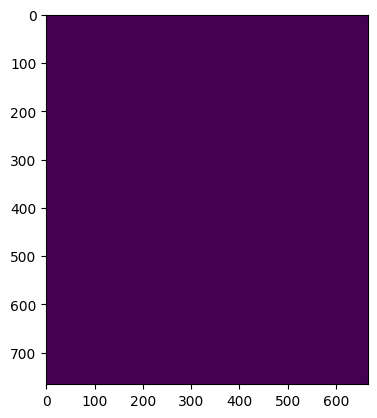

In [4]:
import matplotlib.pyplot as plt

plt.imshow(gui.data_manager.getDictROIImageXYCT()[0]["all"])

In [6]:
gui.control_manager.view_controls["pri"].getPlaneT()

1

In [9]:
np.delete(gui.data_manager.dict_roi_matching["id"][0], 1)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

In [3]:
gui.data_manager.dict_roi_matching["id"]

{}

In [3]:
np.array(list(gui.control_manager.view_controls["pri"].view_handler.handler.roi_points_edit))

array([], dtype=float64)